In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

colors = sns.color_palette()

In [2]:
# Extra parameters
folder = '../../../test/mle/svsim/'
paramfile = '../../../test/mle/svsim/svsim.parm.000'
second_thinning = 1

---------------------------------------
## Read the InputParam file

In [3]:
params = open(paramfile)

InputParams = {}
ThetaParams = {}            

for row in params:
    if row[:22] == 'PARAMETER START VALUES':
        break
        
    if (row[0] != '#') and not (row[:3].isupper()):
        param_type = row.split(',')[-1].strip()
        if param_type == 'char*' or param_type=='string':
            InputParams[row.split(',')[-2][1:]] = row[:12].replace(' ','')
        if param_type == 'int':
            InputParams[row.split(',')[-2][1:]] = int(row[:12].replace(' ',''))
        if param_type == 'float':
            InputParams[row.split(',')[-2][1:]] = float(row[:12].replace(' ',''))
        if param_type == 'intvec':
            var_cols = np.asarray([int(i) for i in row[:12].split(' ') if i!=''])
            InputParams[row.split(',')[-2][1:]] = var_cols
            
for row in params:
    if not (row[:3].isupper()):
        par = row.rsplit(' ', maxsplit=1)[-1].strip()
        ThetaParams[par] = [float(row.lstrip().split(' ')[0])]
        fixed = row.lstrip().split(' ', maxsplit=1)[1].lstrip().split(' ')[0]
        number = row.lstrip().split(' ', maxsplit=1)[1].lstrip().split(' ', maxsplit=1)[1].lstrip().split(' ')[0]
        ThetaParams[par] = ThetaParams[par] + [int(fixed)]
        ThetaParams[par] = ThetaParams[par] + [int(number)]
    else:
        break
        
for row in params:
    if not (row[:3].isupper()):
        par = row.rsplit(' ', maxsplit=1)[-1].strip()
        ThetaParams[par] = ThetaParams[par] + [float(row.lstrip().split(' ')[0])]
    else:
        break

In [4]:
pd.DataFrame(data=InputParams).T

,0
0 Draw from prior if draw_from_prior=1,0
1 Write detailed output if print=1,1
L,1
Lhac,1
M,1
N,5
dsn,svsim.dat
emlimit,50
emmver,1
fields,1


In [5]:
model_params = pd.DataFrame(data=ThetaParams, index=['starting_value', 'active', 'rank', 'proposal_scale']).T
model_params = model_params.reset_index()
model_params = model_params.rename(columns={"index": "params"})
model_params['rank'] = model_params['rank'].astype(int)

------------------------

## Summary

In [6]:
summary = open(folder + InputParams['pname'] + '.summary.dat')
Summary = {}

for row in summary:
    cols = row.split()
    if cols[0] == 'parm':
        for c in cols:
            Summary[c] = []
        break

for row in summary:
    if row.split() == []:
        break
    cols = row.split()
    Summary['parm'] += [cols[0]]
    Summary['rhomean'] += [cols[1]]
    Summary['rhomode'] += [cols[2]]
    Summary['sehess'] += [cols[3]]
    Summary['sesand'] += [np.NaN]
    Summary['seinfo'] += [np.NaN]

    
df_summary = pd.DataFrame(data = Summary)
df_summary = df_summary.rename(columns={'parm':'rank'})
df_summary['rank'] = df_summary['rank'].astype(int)
model_params = pd.merge(model_params, df_summary[['rank', 'rhomode', 'rhomean', 'sehess']], on='rank')
model_params = model_params.sort_values(by='rank')
#model_params.to_csv(folder + 'figures/params_summary.csv')
model_params

,params,starting_value,active,rank,proposal_scale,rhomode,rhomean,sehess
2,rho,0.25,1.0,1,3.125000e-02,0.28833,0.25017,0.10361
1,phi,0.80,1.0,2,1.250000e-01,0.76428,0.7357,0.1474
3,sigma,0.10,1.0,3,1.562500e-02,0.096355,0.089235,0.016508
0,beta,1.00,0.0,4,1.192093e-07,1,1,0


-------------------------------------------
## Build rejection table

In [7]:
#============================================
# Rejection draws
#============================================

reject_draws = np.zeros((InputParams['len_mod_parm'] + 1, 2))

for i in range(InputParams['nfile'] + 1):
    file = pd.read_csv(folder + InputParams['pname'] + '.reject.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    reject_draws += np.asarray(file[2:]).reshape(dim[1], dim[0]).T[:, -2:]

second_col = np.asarray([i/reject_draws[-1,-1] 
                         for i in reject_draws[:, -1]]).reshape(InputParams['len_mod_parm'] + 1, 1)
first_col = []
for i in range(InputParams['len_mod_parm'] + 1):
    if reject_draws[i, -1] != 0.0:
        first_col.append(reject_draws[i, -2]/reject_draws[i, -1])
    else:
        first_col.append(0.0)

first_col = np.asarray(first_col).reshape(InputParams['len_mod_parm'] + 1, 1)        
reject_draws = np.hstack([first_col, second_col, reject_draws])

rejection_table = pd.DataFrame(data=reject_draws, columns=['rejection_rate', 'freq_move', 
                                                           'numb_rejection', 'numb_moves'])

In [8]:
pp = pd.concat([model_params[['rank', 'params']], 
                pd.DataFrame(data={'rank': [5, 6], 'params':['Total', '7']})]).iloc[:-1,:]
pp.reset_index()


rejection_table['rank'] = np.arange(1, InputParams['len_mod_parm'] + 2)
rejection_table = pd.merge(pp, rejection_table, on='rank')

rejection_table = rejection_table.set_index('params')
rejection_table = rejection_table.drop('rank', 1)
#rejection_table.to_csv(folder + 'figures/rejection_table.csv')
rejection_table

,rejection_rate,freq_move,numb_rejection,numb_moves
params,,,,
rho,0.080460,0.348,14.0,174.0
phi,0.230769,0.338,39.0,169.0
sigma,0.343949,0.314,54.0,157.0
beta,0.000000,0.000,0.0,0.0
Total,0.214000,1.000,107.0,500.0


----------------------------------------
## MCMC chain of theta

In [9]:
num_draws = int(InputParams['lchain']*(InputParams['nfile']+1)/InputParams['stride'])
numb_active = int(model_params['active'].sum())
list_all = list(model_params['params'])
list_active = list(model_params[model_params['active']==1]['params'])

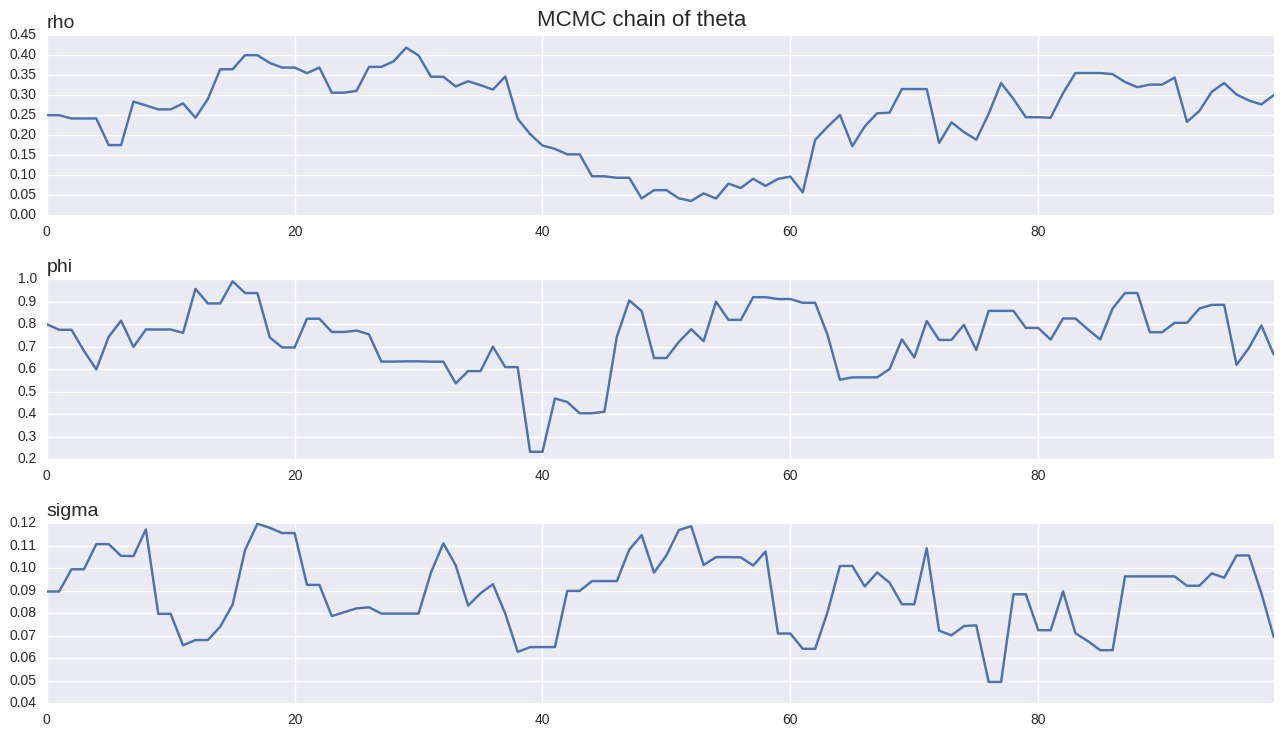

In [10]:
#============================================
# Theta draws
#============================================

theta_draws = pd.DataFrame(data =[])

for i in range(InputParams['nfile'] + 1):
    file = pd.read_csv(folder + InputParams['pname'] + '.rho.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    theta_draws = pd.concat([theta_draws, pd.DataFrame(data=np.asarray(file[2:]).reshape(dim[1], dim[0]))], axis=0)

theta_draws.index = range(num_draws)
theta_draws.columns = list_all

fig, ax = plt.subplots(numb_active, 1, figsize=(13, 2.5*numb_active))
for i, val in enumerate(list_active):
    theta_draws.iloc[::second_thinning, :][val].plot(ax=ax[i])
    ax[i].set_title(val, fontsize=14, loc='left')

plt.suptitle('MCMC chain of theta', fontsize=16)
plt.tight_layout()
#plt.savefig(folder + 'figures/mcmc_chain_theta.png')

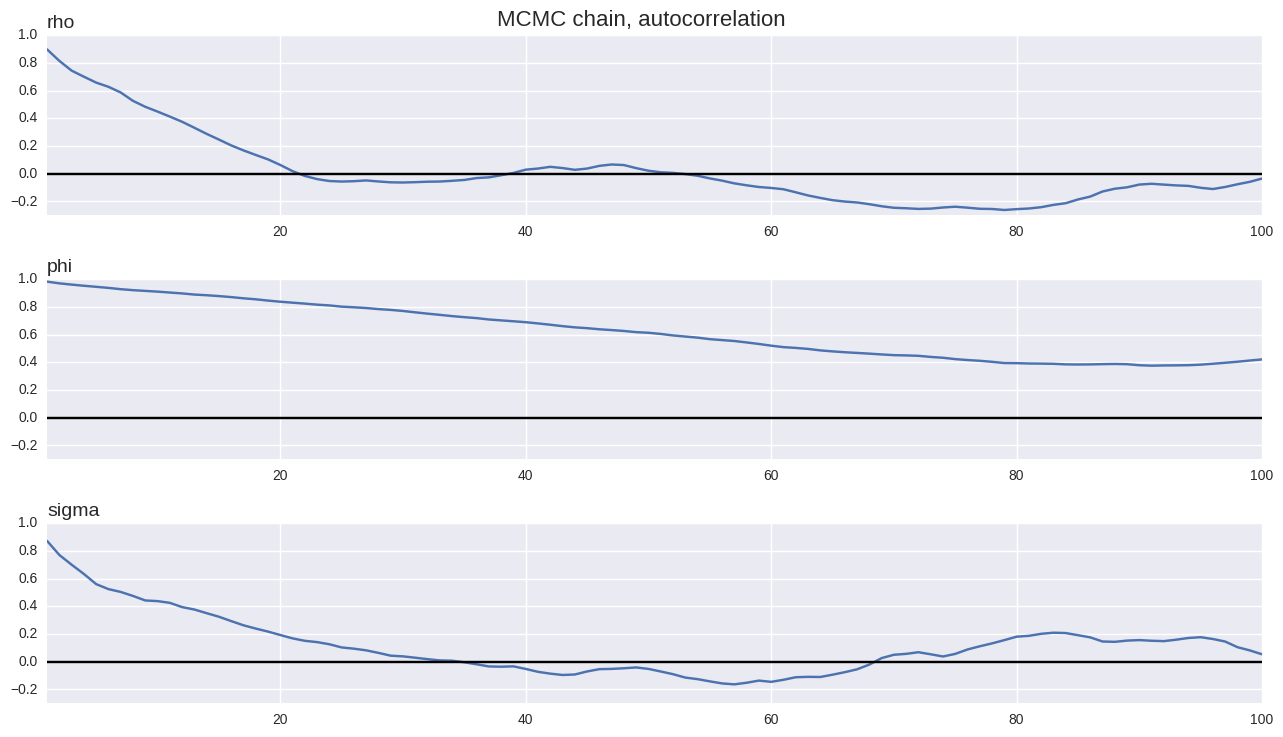

In [11]:
autocorr = np.zeros((numb_active, 100))

for i, val in enumerate(list_active):
    for lag in range(1, 101):
        autocorr[i, lag-1] = theta_draws.iloc[::second_thinning, :][val].autocorr(lag=lag)
AC = pd.DataFrame(data=autocorr.T, columns=list_active, index=np.arange(1, 101))

fig, ax = plt.subplots(numb_active, 1, figsize = (13, 2.5*numb_active))
for i, val in enumerate(list_active):
    AC[val].plot(ax=ax[i])
    ax[i].set_title(val, fontsize=14, loc='left')
    ax[i].axhline(0, color='k')
    ax[i].set_ylim([-.3, 1])
    
fig.suptitle('MCMC chain, autocorrelation', fontsize=16)
plt.tight_layout()
#plt.savefig(folder + 'figures/mcmc_chain_autocorr.png')

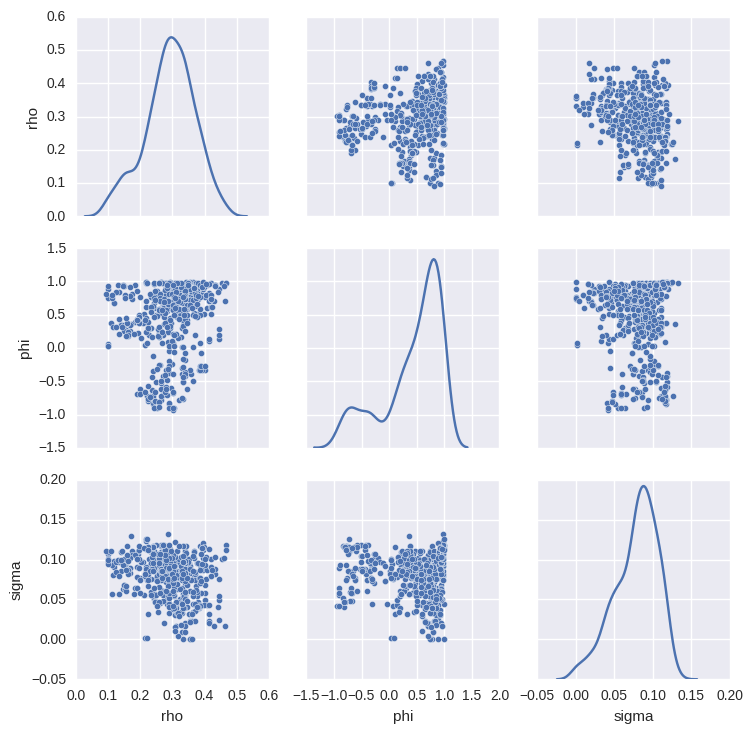

In [12]:
sns.pairplot(theta_draws.iloc[::second_thinning][list_active], diag_kind='kde')
#plt.savefig(folder + 'figures/mcmc_chain_posterior.png')

-------------------------------------
## MCMC chain for theta at times when the particle filter got updated

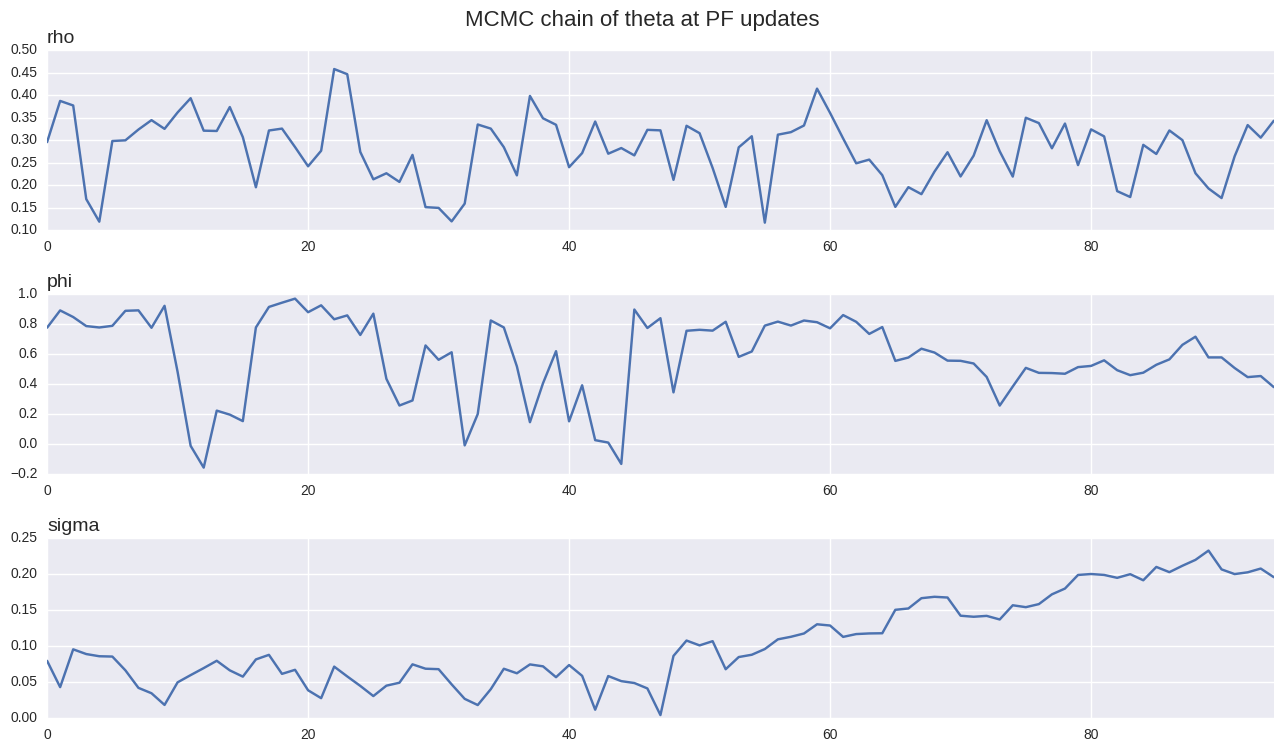

In [29]:
#============================================
# Gibbs draws
#============================================

gibbs_draws = pd.DataFrame(data =[])

for i in range(InputParams['nfile'] + 1):
    file = pd.read_csv(folder + InputParams['pname'] + 
                       '.usrvar.gibbs_draws.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    gibbs_draws = pd.concat([gibbs_draws, 
                                 pd.DataFrame(data=np.asarray(file[2:]).reshape(dim[1], dim[0]))], axis=0)

gibbs_draws.index = range(gibbs_draws.shape[0])
gibbs_draws.columns = list_all

fig, ax = plt.subplots(numb_active, 1, figsize=(13, 2.5*numb_active))
for i, val in enumerate(list_active): 
    gibbs_draws.iloc[:, :][val].plot(ax=ax[i])
    ax[i].set_title(val, fontsize=14, loc='left')
    
plt.suptitle('MCMC chain of theta at PF updates', y=1.0, fontsize=16)
plt.tight_layout()
#plt.savefig(folder + 'figures/gibbs_draws_theta.png')

-------------------
## Posterior (and prior) values along the MCMC chain

In [13]:
#============================================
# Posterior draws
#============================================

pi_draws = pd.DataFrame(data =[])

for i in range(InputParams['num_mcmc_files'] + 1):
    file = pd.read_csv(folder + InputParams['project_name'] + '.pi.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    pi_draws = pd.concat([pi_draws, 
                          pd.DataFrame(data=np.asarray(file[2:]).reshape(dim[1], dim[0]))], axis=0)

pi_draws.index = range(num_draws)
pi_draws.columns = ['posterior', 'likelihood', 'prior']

fig, ax = plt.subplots(3, 1, figsize=(13, 7.5))
pi_draws.iloc[::second_thinning, 0].plot(ax=ax[0])
ax[0].set_title('Posterior value along the MCMC chain')
pi_draws.iloc[::second_thinning, 1].plot(ax=ax[1], color=colors[1])
ax[1].set_title('Likelihood value along the MCMC chain')
pi_draws.iloc[::second_thinning, 2].plot(ax=ax[2], color=colors[2])
ax[2].set_title('Prior value along the MCMC chain')
plt.tight_layout()
plt.savefig(folder + 'figures/posterior_along_chain.png')

KeyError: 'num_mcmc_files'

-------------------------------
## Particle Filter

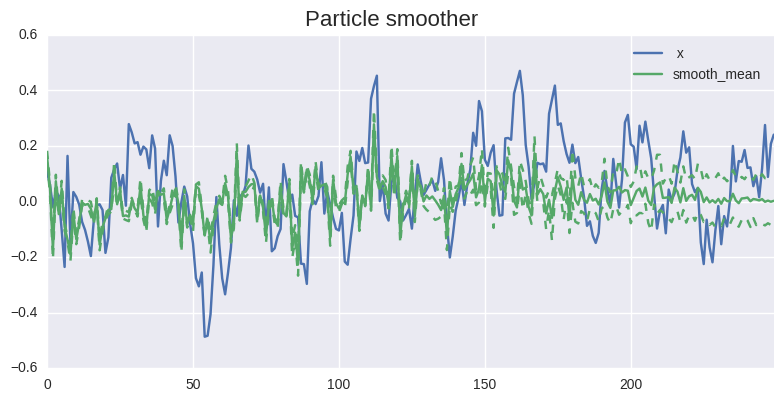

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

particle_filter = pd.read_csv(folder + 'svsim.usrvar.filter.csv')
particle_filter.iloc[:, [-2, 0]].plot(ax=ax)
(particle_filter.iloc[:, 0] + particle_filter.iloc[:, 1]).plot(ax=ax, linestyle='--', color=colors[1])
(particle_filter.iloc[:, 0] - particle_filter.iloc[:, 1]).plot(ax=ax, linestyle='--', color=colors[1])
plt.suptitle('Particle smoother', fontsize=16, y=1.0)
plt.tight_layout()
#plt.savefig(folder + 'figures/particle_smoother.png')

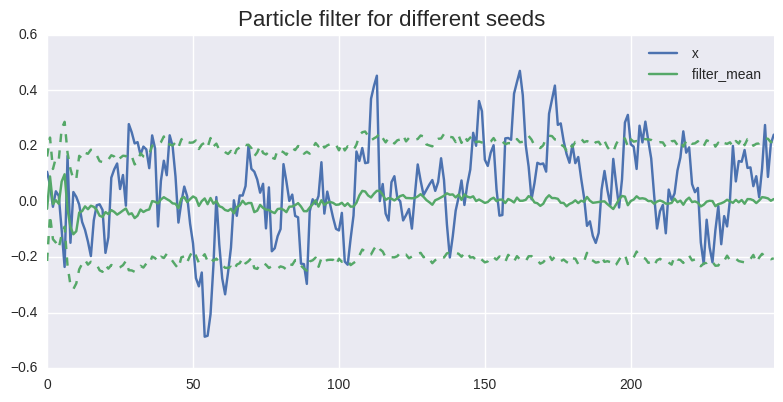

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

particle_filter = pd.read_csv(folder + '/svsim.usrvar.filter.csv')
particle_filter.iloc[:, [-2, 2]].plot(ax=ax)
(particle_filter.iloc[:, 2] + particle_filter.iloc[:, 3]).plot(ax=ax, linestyle='--', color=colors[1])
(particle_filter.iloc[:, 2] - particle_filter.iloc[:, 3]).plot(ax=ax, linestyle='--', color=colors[1])
plt.suptitle('Particle filter for different seeds', fontsize=16, y=1.0)
plt.tight_layout()
#plt.savefig(folder + 'figures/particle_filter.png')

(-0.6, 0.6)

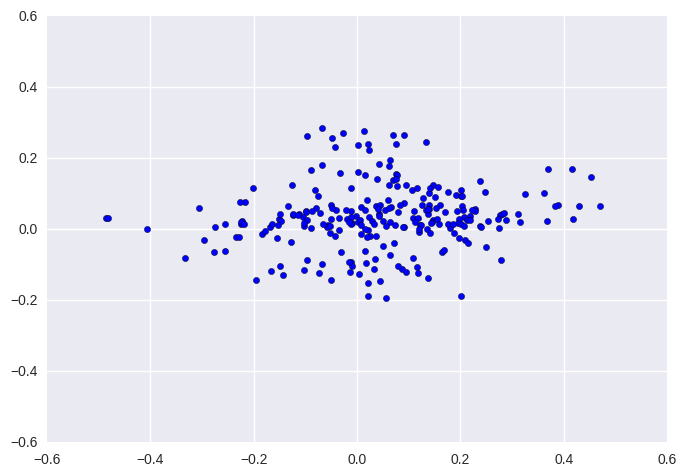

In [18]:
plt.scatter(x=particle_filter.iloc[:, -2], y=particle_filter.iloc[:, 0])
plt.xlim([-.6, .6])
plt.ylim([-.6, .6])

(-0.6, 0.6)

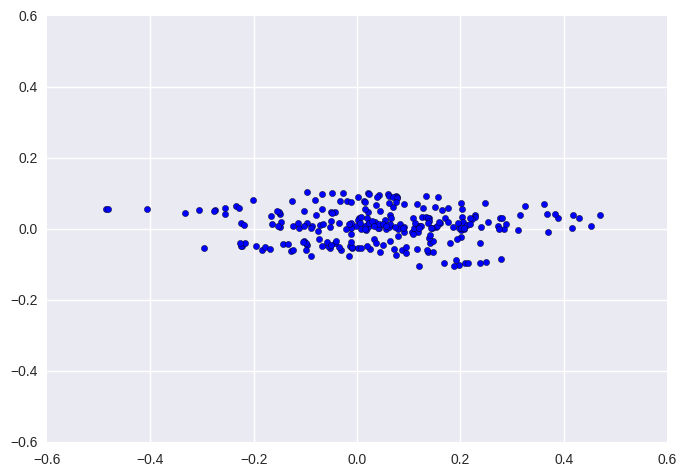

In [19]:
plt.scatter(x=particle_filter.iloc[:, -2], y=particle_filter.iloc[:, 2])
plt.xlim([-.6, .6])
plt.ylim([-.6, .6])

--------------------------------------
## Read data

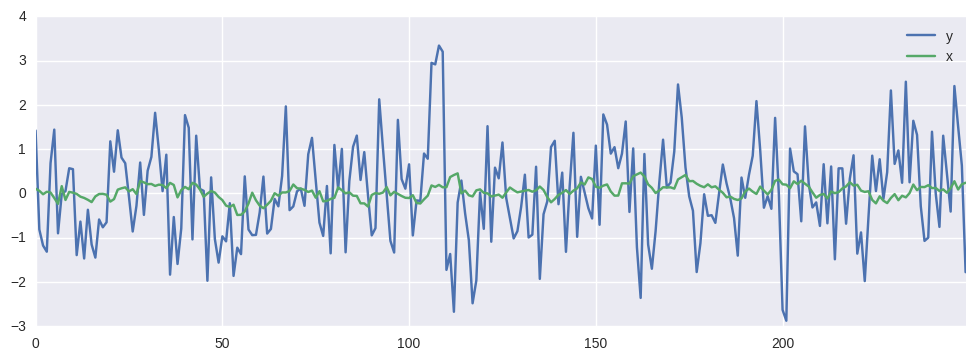

In [18]:
sample_size = InputParams['n']
data = pd.read_csv(folder + 'svsim.dat', sep='\s+', header=None)
data.columns = ['y', 'x']
data = data[:sample_size]

fig, ax = plt.subplots(figsize=(12, 4))
data.plot(ax=ax)

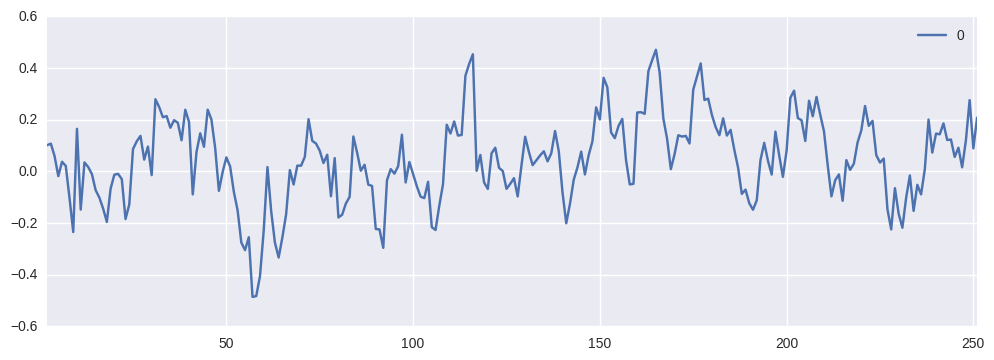

In [19]:
true_x = pd.read_csv(folder + 'svparticle.dat', sep='\s+', header=None)
true_x_dim = np.asarray(true_x[:2], dtype=int)
true_x = true_x[2:sample_size+2]

fig, ax = plt.subplots(figsize=(12, 4))
true_x.plot(ax=ax)